<a href="https://colab.research.google.com/github/Arzamazov/VAE_research/blob/master/betaVAE_on_dSprites_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DISENTANGLED REPRESENTATION IN VAE ON DSPRITES DATASET

###Import

In [4]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from keras.layers import BatchNormalization, Dropout, Lambda, Reshape, Input, Dense, Flatten, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model, model_from_json

from keras.objectives import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits import mplot3d
%matplotlib inline

###Loading data

In [5]:
# Load dataset
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes', allow_pickle=True)

print('Keys in the dataset:', dataset_zip.keys())
imgs = dataset_zip['imgs']
imgs = np.array(imgs).reshape(np.array(imgs).shape[0], np.array(imgs).shape[1], np.array(imgs).shape[2], 1)
latents_values = dataset_zip['latents_values']
latents_classes = dataset_zip['latents_classes']
metadata = dataset_zip['metadata'][()]

print('Metadata: \n', metadata)

FileNotFoundError: [Errno 2] No such file or directory: 'dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'

In [0]:
# Define number of values per latents and functions to convert to indices
latents_sizes = metadata[b'latents_sizes']

latents_bases = np.concatenate((latents_sizes[::-1].cumprod()[::-1][1:], np.array([1,])))

def latent_to_index(latents):
  return np.dot(latents, latents_bases).astype(int)

def sample_latent(size=1, latent=latents_sizes):
  samples = np.zeros((size, latent.size))
  for lat_i, lat_size in enumerate(latent):
    samples[:, lat_i] = np.random.randint(lat_size, size=size)

  return samples

# Helper function to show images
def show_images_grid(imgs_, num_images=25):
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()

  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')

def show_density(imgs):
  _, ax = plt.subplots()
  ax.imshow(imgs.mean(axis=0), interpolation='nearest', cmap='Greys_r')
  ax.grid('off')
  ax.set_xticks([])
  ax.set_yticks([])

###Building model

In [0]:
def build_VAE(img_side=64, latent_dim = 6, beta=1.0, drop_rate=0.0, C=0.0):
  
  x_input = Input(batch_shape=(None, img_side, img_side, 1))
  
  def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(x_input)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(z_log_sigma) * epsilon
  
  def downConvBlock(x_input, units):
    x = Conv2D(units, (3,3), activation='relu', padding='same')(x_input)
    x = Dropout(rate=drop_rate)(x)
    return MaxPooling2D((2,2), padding='same')(x)
  
  def upConvBlock(x_input, units):
    x = Conv2D(units, (3,3), activation='relu', padding='same')(x_input)
    x = Dropout(rate=drop_rate)(x)
    return UpSampling2D((2,2))(x)
  
  x = downConvBlock(x_input, 256) #to32x32
  x = downConvBlock(x, 32) #to16x16
  x = downConvBlock(x, 32) #to8x8
  x = Flatten()(x)
  x = Dense(100, activation='relu')(x)
  x = Dropout(rate=drop_rate)(x)
  
  mean_encoded = Dense(latent_dim)(x)
  sigma_encoded = Dense(latent_dim)(x)
  
  l = Lambda(sampling, output_shape=(latent_dim,))([mean_encoded, sigma_encoded])
  
  encoder = Model(x_input, mean_encoded)
  encoder_l = Model(x_input, l)
  decoder_input = Input(batch_shape=(None, latent_dim))
  
  x = Dense(100, activation='relu')(decoder_input)
  x = Dropout(rate=drop_rate)(x)
  x = Dense(8*8*32, activation='relu')(x)
  x = Reshape((8, 8, 32))(x)
  x = upConvBlock(x, 64) #to16x16
  x = upConvBlock(x, 64) #to32x32
  x = upConvBlock(x, 64) #to64x64
  x = Dropout(rate=drop_rate)(x)
  
  decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
  sampling_decoder = Model(decoder_input, decoded)
  decoder = Model(decoder_input, decoded)
  vae = Model(x_input, decoder(encoder_l(x_input)))
  
  def vae_loss(x, x_pred):
    x = K.reshape(x, shape=(-1, img_side*img_side))
    x_pred = K.reshape(x_pred, shape=(-1, img_side*img_side))
    reconstruction_loss = binary_crossentropy(x, x_pred) * img_side * img_side
    kl_loss = - 0.5 * K.sum(1 + sigma_encoded - K.square(mean_encoded) - K.exp(sigma_encoded), axis = -1)
    kl_loss = np.absolute(kl_loss - C) * beta
    return (reconstruction_loss + kl_loss) / (img_side * img_side)
  
  return encoder, sampling_decoder, vae, vae_loss

###Setting params

In [0]:
batch_size = 128
epochs = 10
beta_mod = np.ones(1)
#beta_mod = np.linspace(0, 2, 3) * 25 + 50
models = np.ones(1)
latent_dim = 10
img_size = 64
C=0

###Loading ensemble of models

In [0]:
_, _, _, vae_loss = build_VAE()
x_input = Input(batch_shape=(None, img_size, img_size, 1))

encoders = []
decoders = []
vaes = []

for model_ind, _ in enumerate(models):
  encoder_file = open("encoder"+str(model_ind)+"_model.json", "r")
  decoder_file = open("decoder"+str(model_ind)+"_model.json", "r")
  loaded_encoder_json = encoder_file.read()
  loaded_decoder_json = decoder_file.read()
  encoder_file.close()
  decoder_file.close()
  encoder = model_from_json(loaded_encoder_json)
  decoder = model_from_json(loaded_decoder_json)
  encoder.load_weights("encoder"+str(model_ind)+"_model.h5")
  decoder.load_weights("decoder"+str(model_ind)+"_model.h5")
  vae = Model(x_input, decoder(encoder(x_input)))
  
  vae.compile(optimizer=Adam(lr = 0.001), loss=vae_loss)
  
  encoders.append(encoder)
  decoders.append(decoder)
  vaes.append(vae)
  

Instructions for updating:
Colocations handled automatically by placer.


###Compiling models

In [0]:
encoders = []
decoders = []
vaes = []

for i, val in enumerate(models):
  encoder, decoder, vae, vae_loss = build_VAE(beta=beta_mod[i]**val, latent_dim=latent_dim, C=C, drop_rate=0)
  vae.compile(optimizer=Adam(lr = 0.001), loss=vae_loss)
  encoders.append(encoder)
  decoders.append(decoder)
  vaes.append(vae)

###Summary

In [31]:
vaes[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
model_17 (Model)             (None, 10)                292488    
_________________________________________________________________
model_19 (Model)             (None, 64, 64, 1)         300877    
Total params: 593,365
Trainable params: 593,365
Non-trainable params: 0
_________________________________________________________________


In [32]:
encoders[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 64, 64, 256)       2560      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64, 64, 256)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 32)        73760     
_________________________________________________________________
dropout_29 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
__________

In [33]:
decoders[0].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1100      
_________________________________________________________________
dropout_32 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2048)              206848    
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
dropout_33 (Dropout)         (None, 8, 8, 64)          0         
__________

###Learning ensemble of models

In [34]:
history = []
for i, val in enumerate(models):
  print("Model "+str(i+1))
  hist = vaes[i].fit(imgs, imgs,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1)
  history.append(hist)

Model 1
Epoch 1/10
737280/737280 [==============================] - 668s 906us/step - loss: 0.0189
Epoch 2/10
737280/737280 [==============================] - 669s 908us/step - loss: 0.0109
Epoch 3/10
737280/737280 [==============================] - 668s 906us/step - loss: 0.0093
Epoch 4/10
737280/737280 [==============================] - 666s 903us/step - loss: 0.0085
Epoch 5/10
737280/737280 [==============================] - 666s 904us/step - loss: 0.0081
Epoch 6/10
737280/737280 [==============================] - 672s 911us/step - loss: 0.0079
Epoch 7/10
737280/737280 [==============================] - 666s 904us/step - loss: 0.0077
Epoch 8/10
737280/737280 [==============================] - 668s 906us/step - loss: 0.0075
Epoch 9/10
737280/737280 [==============================] - 670s 908us/step - loss: 0.0074
Epoch 10/10
737280/737280 [==============================] - 678s 919us/step - loss: 0.0073


##SAVING RESULTS

### 1. Model

**Ensemble of models**

In [0]:
for i, _ in enumerate(models):
  encoder_json = encoders[i].to_json()
  decoder_json = decoders[i].to_json()

  encoder_file = open("encoder"+str(i)+"_model.json", "w")
  decoder_file = open("decoder"+str(i)+"_model.json", "w")
  encoder_file.write(encoder_json)
  encoder_file.close()
  decoder_file.write(decoder_json)
  decoder_file.close()
  encoders[i].save_weights("encoder"+str(i)+"_model.h5")
  decoders[i].save_weights("decoder"+str(i)+"_model.h5")

###2. Loss plot (optional)

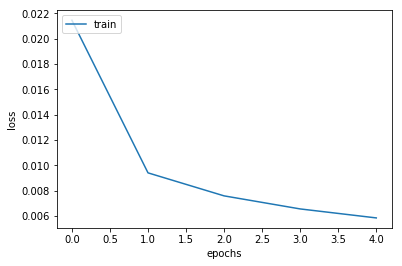

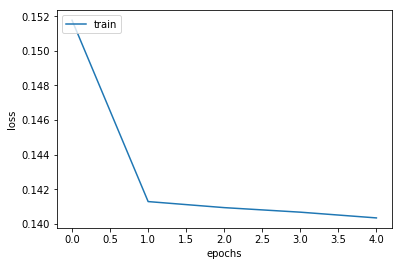

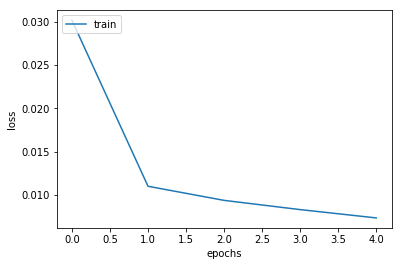

In [0]:
for i, _ in enumerate(models):
  plt.plot(history[i].history['loss'])
  plt.title('')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train'], loc='upper left')
  plt.show()

###3. Scatter plot of latent space

In [0]:
for i, val in enumerate(models):
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")
  imgs_encoded = encoders[i].predict(imgs, batch_size=64)
  imgs_encoded = PCA(n_components=3).fit_transform(imgs_encoded)

  ax.scatter3D(imgs_encoded[:, 0], imgs_encoded[:, 1], imgs_encoded[:, 2], s=1, c=latents_classes[:,4], zdir='z', cmap='RdBu');
  #plt.colorbar()
  plt.title(str(latent_dim)+"-dimentional latent space in 3 dimentions - position X (beta="+str(beta_mod**val)+")")
  plt.show()

In [0]:
for i, val in enumerate(models):
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")
  imgs_encoded = encoders[i].predict(imgs, batch_size=64)
  imgs_encoded = PCA(n_components=3).fit_transform(imgs_encoded)

  ax.scatter3D(imgs_encoded[:, 0], imgs_encoded[:, 1], imgs_encoded[:, 2], s=1, c=latents_classes[:,5], zdir='z', cmap='RdBu');
  #plt.colorbar()
  plt.title(str(latent_dim)+"-dimentional latent space in 3 dimentions - position Y (beta="+str(beta_mod**val)+")")
  plt.show()

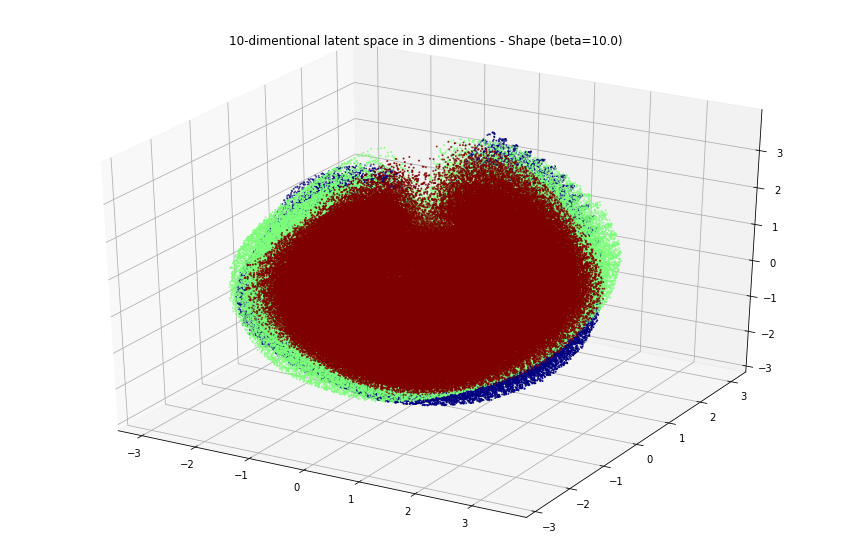

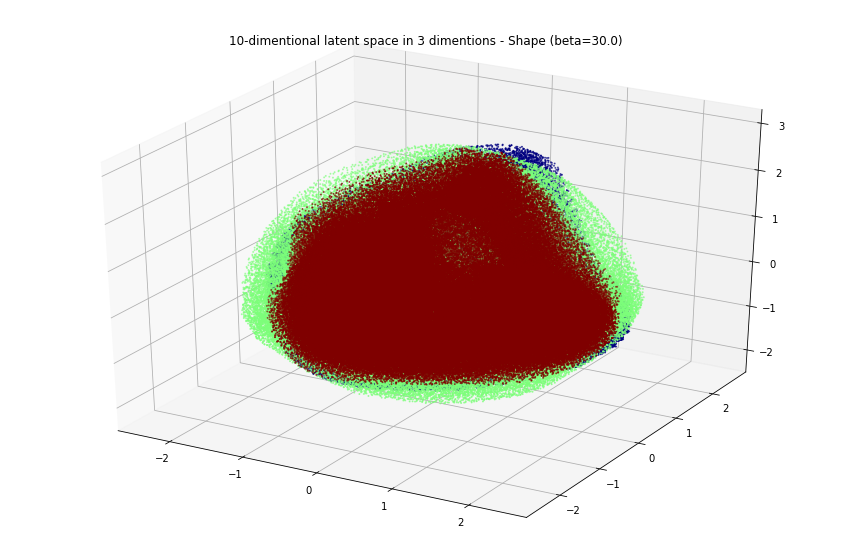

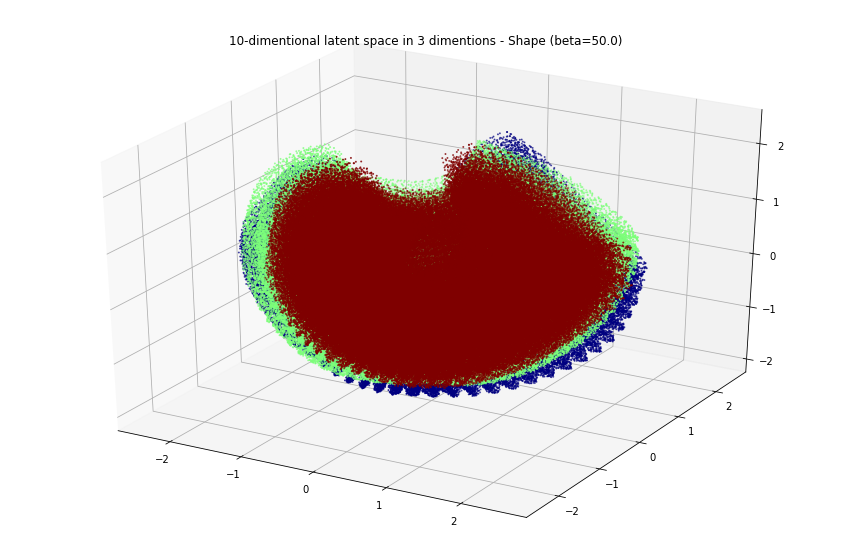

In [0]:
for i, val in enumerate(models):
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")
  imgs_encoded = encoders[i].predict(imgs, batch_size=64)
  imgs_encoded = PCA(n_components=3).fit_transform(imgs_encoded)

  ax.scatter3D(imgs_encoded[:, 0], imgs_encoded[:, 1], imgs_encoded[:, 2], s=1, c=latents_classes[:,1], zdir='z', cmap='jet');
  #plt.colorbar()
  plt.title(str(latent_dim)+"-dimentional latent space in 3 dimentions - Shape (beta="+str(beta_mod[i]**val)+")")
  plt.show()

In [0]:
for i, val in enumerate(models):
  imgs_encoded = encoders[i].predict(imgs, batch_size=64)
  imgs_encoded = PCA(n_components=3).fit_transform(imgs_encoded)
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")

  ax.scatter3D(imgs_encoded[:, 0], imgs_encoded[:, 1], imgs_encoded[:, 2], s=1, c=latents_classes[:,2], zdir='y', cmap='RdBu');
  #plt.colorbar()
  plt.title(str(latent_dim)+"-dimentional latent space in 3 dimentions - Size (beta="+str(beta_mod**val)+")")
  plt.show()

In [0]:
for i, val in enumerate(models):
  imgs_encoded = encoders[i].predict(imgs, batch_size=64)
  imgs_encoded = PCA(n_components=3).fit_transform(imgs_encoded)
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")

  ax.scatter3D(imgs_encoded[:, 0], imgs_encoded[:, 1], imgs_encoded[:, 2], s=1, c=latents_classes[:,3], zdir='z', cmap='RdBu');
  #plt.colorbar()
  plt.title(str(latent_dim)+"-dimentional latent space in 3 dimentions - Orientation (beta="+str(beta_mod**val)+")")
  plt.show()

###4. Sampling

**Getting latent vector of object from train for sampling**

In [40]:
latents_sampled = sample_latent(size=1)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 0 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 5 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos

imgs_sampled = imgs[latent_to_index(latents_sampled)]

latents = []
for j, _ in enumerate(models):  
  print("Model"+str(j+1))
  latent = encoders[j].predict(imgs_sampled)
  latents.append(latent)
  for i in range(latent_dim):
    print(str(latent[0][i])+", ")
  print(" ")

Model1
-1.5650796, 
0.6468134, 
-1.2456114, 
0.049770962, 
1.2442144, 
2.18535, 
-1.6323549, 
-1.0024796, 
-0.084269255, 
0.31282383, 
 


###Changing each latent unit of models in ensemble

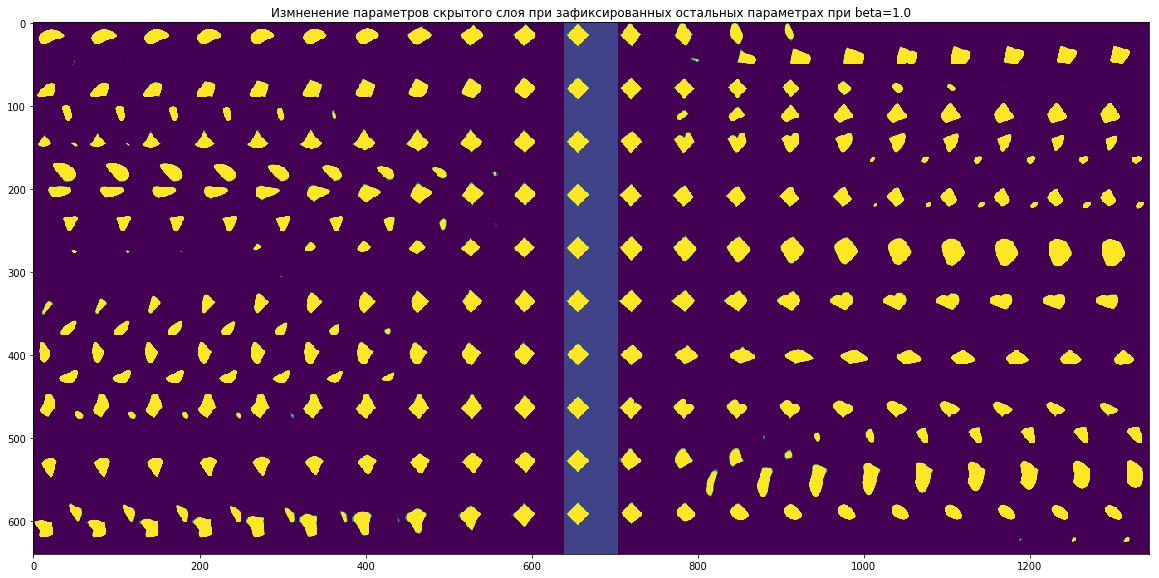

In [41]:
for m, val in enumerate(models):
  n = 21
  ran = 5
  figure = np.zeros((latent_dim * img_size, img_size * n))
  grid_x = np.linspace(-ran, ran, n)

  z_sample = np.array(latents[m])
  for k in range(latent_dim):
    z = z_sample[0][k]
    g = np.array(grid_x + z_sample[0][k])
    for i, yi in enumerate(grid_x):
      z_sample[0][k]=g[i]
      x_decoded = decoders[m].predict(z_sample)
      shape = x_decoded[0].reshape(img_size, img_size)
      if (i == np.floor(n/2)):
        shape = shape.clip(0.2,1)
      figure[k * img_size: (k + 1) * img_size,
             i * img_size: (i + 1) * img_size] = shape
    z_sample[0][k] = z

  plt.figure(figsize=(20, 21))
  plt.imshow(figure)
  plt.title("Измненение параметров скрытого слоя при зафиксированных остальных параметрах при beta="+str(beta_mod[m]**val))

  plt.show()

###Animation

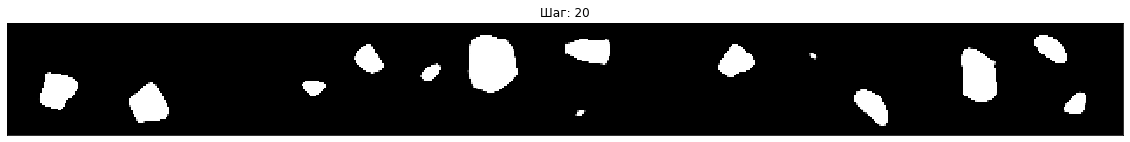

In [42]:
def make_2d_figs_gif(figs, steps, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((img_size,img_size*latent_dim)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("step: " + str(steps[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Шаг: " + str(steps[i-1]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    anim.save(fname, dpi=80, writer='pillow')

for m, _ in enumerate(models):
  #print("Model"+str(m+1))
  figs = []
  n = 21
  steps = np.arange(n) + 1
  ran = 10
  grid_x = np.linspace(-ran, ran, n)

  z_sample = np.array(latents[m])
  for i, xi in enumerate(grid_x):
    figure = np.zeros((img_size, img_size * latent_dim))
    z = z_sample[0]
    for k in range(latent_dim):
      z_sample[0][k]=z[k] + xi
      #print(z_sample[0])
      x_decoded = decoders[m].predict(z_sample)
      shape = x_decoded[0].reshape(img_size, img_size)
      #if ((i == np.floor(n/2)) or (i == np.floor(n/2) + 1) or (i == np.floor(n/2)-1)):
        #shape = shape.clip(0.3,1)
      #elif ((i == np.floor(n/2) - 2) or (i == np.floor(n/2) + 2) or (i == np.floor(n/2) - 3) or (i == np.floor(n/2) + 3)):
        #shape = shape.clip(0.1,1)
      figure[0: img_size,
             k * img_size: (k + 1) * img_size] = shape
      z_sample[0][k] = z[k] - xi
    figs.append(figure)

  make_2d_figs_gif(figs, steps, "latent_units_"+str(m)+".gif", plt.figure(figsize=(20,3)))

###5. Reconstruction original images

**Random sampling**

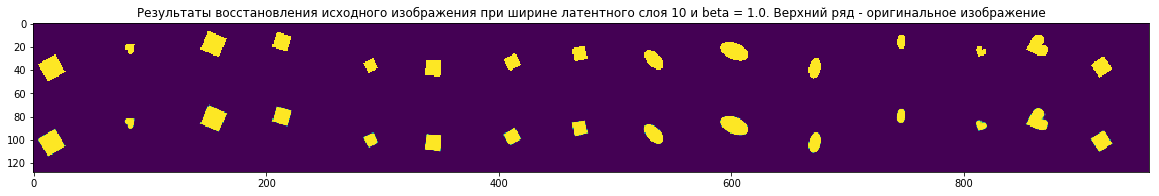

In [38]:
n = 15
imgs_sampled = imgs[latent_to_index(sample_latent(size=n))]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod[k]**val)
  if (k != len(models) - 1):
    s += ", "
s += ". Верхний ряд - оригинальное изображение"

plt.title(s)
plt.imshow(figure)

plt.show()

**Customizable sampling**

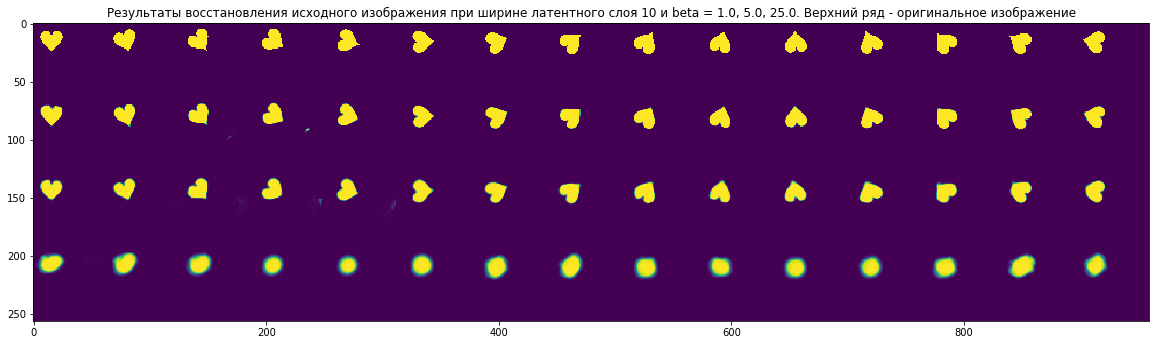

In [0]:
n = 15
latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 2 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,3] = i * 2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))

figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)

plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1):
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 0 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,5] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1):
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

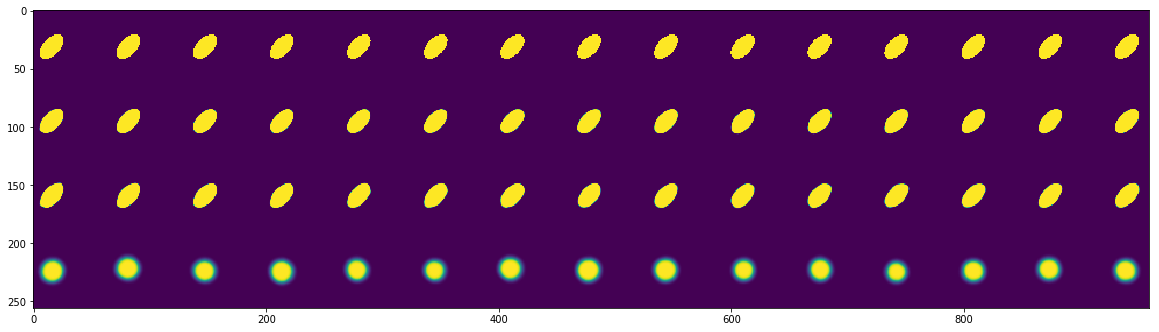

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 1 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 5 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 15 #y_pos
for i in range(n):
  latents_sampled[i,4] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

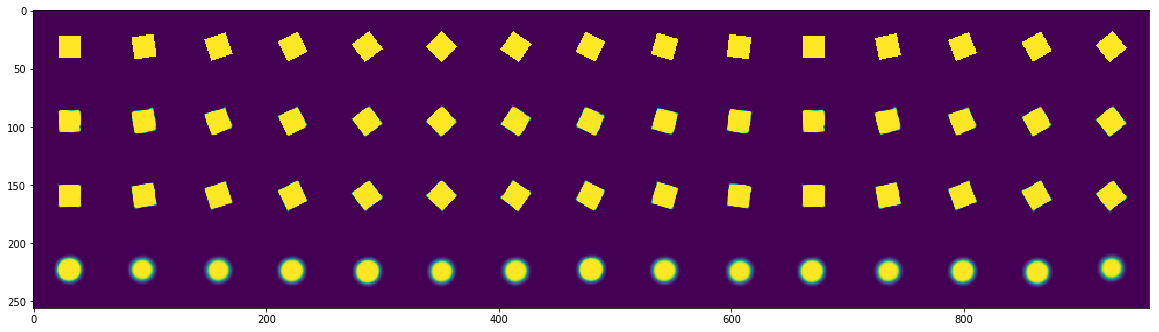

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 0 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 15 #x_pos
latents_sampled[:, 5] = 15 #y_pos
for i in range(n):
  latents_sampled[i,3] = i
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))

s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

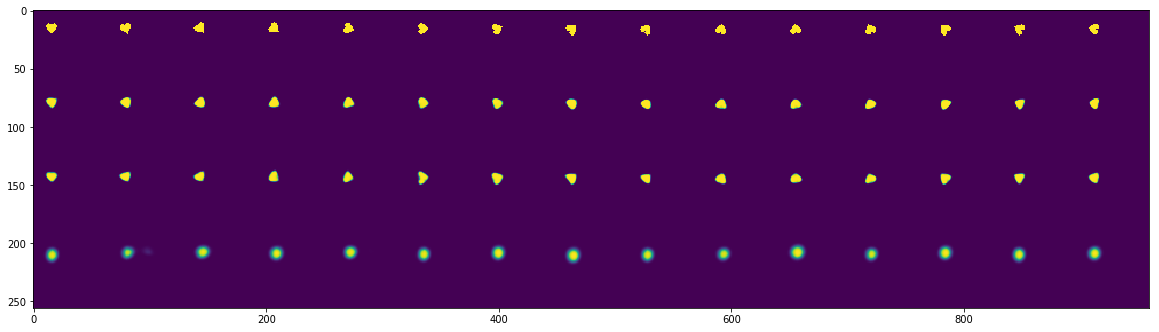

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 2 #shape
latents_sampled[:, 2] = 0 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,3] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

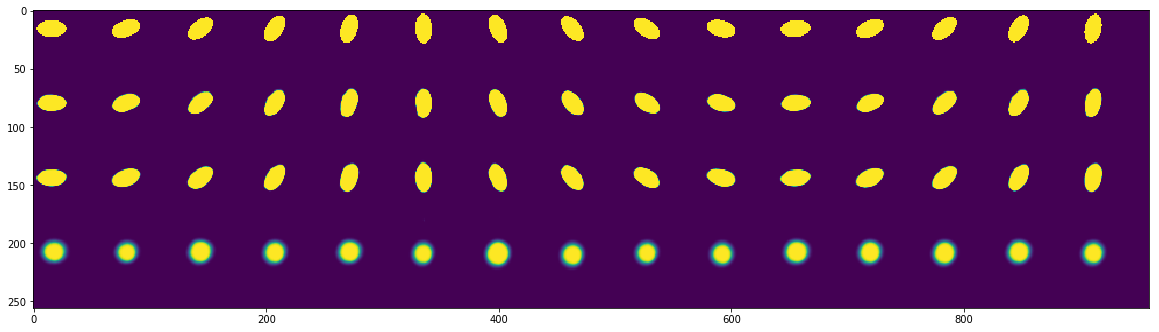

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 1 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,3] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

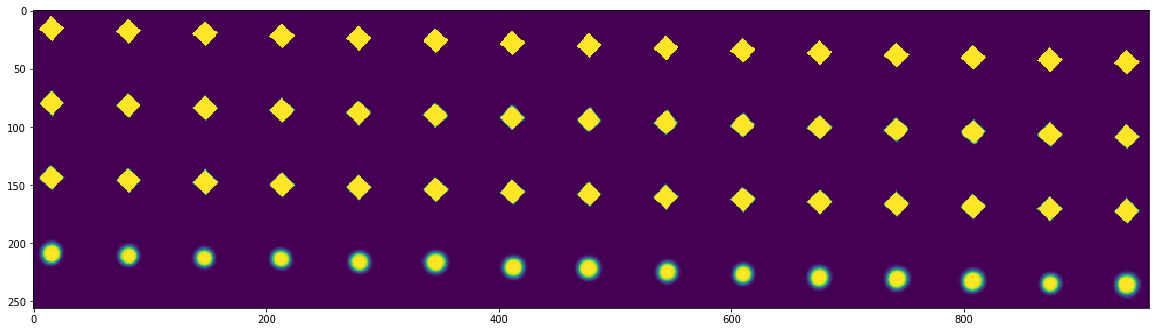

In [0]:
n=15

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 0 #shape
latents_sampled[:, 2] = 3 #size
latents_sampled[:, 3] = 5 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,4] = i*2
  latents_sampled[i,5] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()

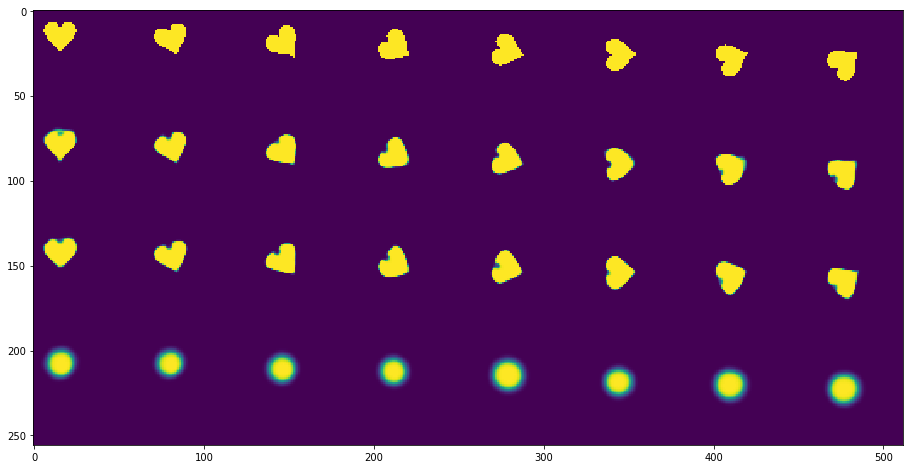

In [0]:
n=8

latents_sampled = sample_latent(size=n)

latents_sampled[:, 0] = 0 #color
latents_sampled[:, 1] = 2 #shape
latents_sampled[:, 2] = 5 #size
latents_sampled[:, 3] = 0 #orientation
latents_sampled[:, 4] = 0 #x_pos
latents_sampled[:, 5] = 0 #y_pos
for i in range(n):
  latents_sampled[i,4] = i*2
  latents_sampled[i,5] = i*2
  latents_sampled[i,3] = i*2
  
imgs_sampled = imgs[latent_to_index(latents_sampled)]

y_pred = []
for k, _ in enumerate(models):
  y_pred.append(vaes[k].predict(imgs_sampled))
  
figure = np.zeros(((len(models) + 1) * img_size, img_size * n))

for i, digit in enumerate(imgs_sampled):
  figure[0:img_size, i * img_size: (i + 1) * img_size] = digit.reshape(img_size, img_size)

for k, _ in enumerate(models):
  for i in range(n):
    figure[(k + 1) * img_size: (k + 2) * img_size, i * img_size: (i + 1) * img_size] = y_pred[k][i].reshape(img_size, img_size)
    
plt.figure(figsize=(20, 8))
s = "Результаты восстановления исходного изображения при ширине латентного слоя "+str(latent_dim)+" и beta = "
for k, val in enumerate(models):
  s += str(beta_mod**val)
  if (k != len(models) - 1)
    s += ", "
s += ". Верхний ряд - оригинальное изображение"
plt.title(s)

plt.imshow(figure)

plt.show()